In [1]:
import os
import numpy as np
import healpy as hp
import pylab as plt
import ccgpack as ccg
import seekstring as ss
import tensorflow as tf

/home/gf/packages/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
g = hp.read_map('../data/gaussian/1.fits',nest=1,verbose=0)
s = hp.read_map('../data/string/map1n_allz_rtaapixlw_2048_1.fits',nest=1,verbose=0)

In [3]:
g_ps = ccg.sky2face(g)

In [4]:
s_ps = ccg.sky2face(s)

In [5]:
g_ps.std()

0.0001104866

In [6]:
s_ps.std()

18.405106

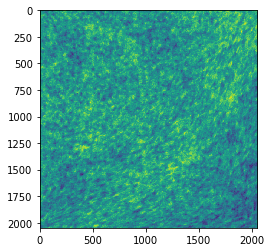

In [7]:
plt.imshow(g_ps[0])

In [8]:
def dp_total(n):
    
    l = 200
    
    x = []
    y = []
    for i in range(n):
        
        gm = np.random.uniform(2.0e-7,9.0e-7)
    
        rg,rs = np.random.randint(0,12,2)
        ri,rj = np.random.randint(0,2048-l,2)
        gp = g_ps[rg][ri:ri+l,rj:rj+l]
        ri,rj = np.random.randint(0,2048-l,2)
        sp = s_ps[rs][ri:ri+l,rj:rj+l]
        
        x.append(gp+gm*sp)
        #x.append(ccg.filter(gp+gm*sp))
        y.append(gm)
    
    return np.expand_dims(np.array(x),-1),np.array(y)


In [9]:
n=300
l=200

In [10]:
x,y = dp_total(n)
print (x.shape,y.shape)

((300, 200, 200, 1), (300,))


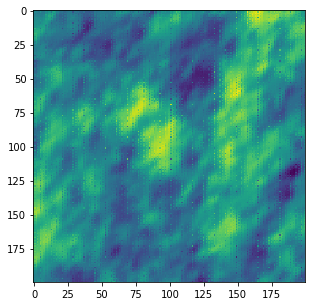

In [11]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.imshow(x[0,:,:,0])

In [12]:
nx,ny,n_channel = l,l,1

x_in = tf.placeholder(tf.float32,[None,nx,ny,n_channel])
y_true = tf.placeholder(tf.float32,[None])
learning_rate = tf.placeholder(tf.float32)
drop_out = tf.placeholder(tf.float32)

x = tf.layers.conv2d(x_in,filters=16,kernel_size=5,strides=(2, 2),padding='same',
        activation=tf.nn.relu)
x = tf.layers.average_pooling2d(x,pool_size=2,strides=2)

x = tf.layers.dropout(x, drop_out)
x = tf.layers.conv2d(x,filters=1,kernel_size=5,strides=(2, 2),padding='same',
        activation=tf.nn.relu)

x = tf.contrib.layers.flatten(x)
x = tf.layers.dense(x, 10 , activation=tf.nn.relu)
y_out = tf.layers.dense(x, 1 ,activation=tf.nn.relu)


cost = tf.reduce_sum(tf.pow(y_true - y_out, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
for i in range(10):
    x,y= dp_total(n)
    train_image=x
    train_label=y
    _,c = sess.run([optimizer, cost], feed_dict=
                     {x_in: train_image, y_true: train_label, drop_out: 0.7, learning_rate: 0.001})
    
    print ('Iter=',i+1, ':' ,c)

('Iter=', 1, ':', 1.3805477e-06)
('Iter=', 2, ':', 3.249906e-08)
('Iter=', 3, ':', 3.1589654e-08)
('Iter=', 4, ':', 3.0000976e-08)
('Iter=', 5, ':', 3.0181347e-08)
('Iter=', 6, ':', 3.199868e-08)
('Iter=', 7, ':', 3.155654e-08)
('Iter=', 8, ':', 3.1091602e-08)
('Iter=', 9, ':', 3.1809513e-08)
('Iter=', 10, ':', 3.04912e-08)


In [19]:
for i in range(10):    
    x,y= dp_total(n)
    train_image=x
    train_label=y

    pred = sess.run(y_out, feed_dict={x_in: x})
#     print(pred)
    print ('Averaged relative error in each batch =',np.mean((pred-train_label)/train_label))

('Averaged relative error in each batch =', -1.0)
('Averaged relative error in each batch =', -1.0)
('Averaged relative error in each batch =', -1.0)
('Averaged relative error in each batch =', -1.0)
('Averaged relative error in each batch =', -1.0)
('Averaged relative error in each batch =', -1.0)
('Averaged relative error in each batch =', -1.0)
('Averaged relative error in each batch =', -1.0)
('Averaged relative error in each batch =', -1.0)
('Averaged relative error in each batch =', -1.0)
